# Implementation of a KAN for classification
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of classification and compare it against a neural network of a similar architecture.

## Initialisations

## Creating and Training the KAN

In [1]:
from fastkan import FastKAN as KAN 
import pandas as pd  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
import random
from scipy.stats import poisson
# Display the noisy images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Adding Noise 

In [3]:
class AddGaussianNoise:
    def __init__(self, mean=0, var=0.00056):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        sigma = self.var ** 0.5
        gaussian = np.random.normal(self.mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSpeckleNoise:
    def __init__(self, mean=0, var=0.0012):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        gaussian = np.random.normal(self.mean, self.var ** 0.5, image.shape)
        noisy_image = np.clip(image + image * gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSaltAndPepperNoise:
    def __init__(self, salt_prob=0.00971, pepper_prob=0.00974):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, image):
        noisy_image = image
        salt_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.salt_prob, self.salt_prob])
        pepper_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.pepper_prob, self.pepper_prob])
        noisy_image[salt_mask == 1] = 1
        noisy_image[pepper_mask == 1] = 0
        return torch.tensor(noisy_image).float()

class AddPoissonNoise:
    def __init__(self, scale_factor=1090, clip_min=0, clip_max=1):
        self.scale_factor = scale_factor
        self.clip_min = clip_min
        self.clip_max = clip_max

    def __call__(self, image):
        if self.scale_factor is None:
            vals = len(np.unique(image))
            scale_factor = 2 ** np.ceil(np.log2(vals))
        else:
            scale_factor = self.scale_factor

        noisy_image = np.random.poisson(image * scale_factor) / float(scale_factor)
        noisy_image = np.clip(noisy_image, self.clip_min, self.clip_max)
        return torch.tensor(noisy_image).float()

class AddOcclusionNoise:
    def __init__(self, size=0.2790):
        self.size = size

    def __call__(self, image):
        noisy_image = image
        h, w, _ = image.shape
        occlusion_size = int(min(h, w) * self.size)
        x = random.randint(0, w - occlusion_size)
        y = random.randint(0, h - occlusion_size)
        noisy_image[y:y+occlusion_size, x:x+occlusion_size] = 0
        return torch.tensor(noisy_image).float()

Loading Dataset

In [4]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    AddOcclusionNoise(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    AddOcclusionNoise(),
])

# Load the dataset
trainset = torchvision.datasets.CIFAR100(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", train=True, download=False, transform=transform
)
valset = torchvision.datasets.CIFAR100(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", train=False, download=False, transform=transform_test
)
train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


In [5]:
# Get a batch of images
#dataiter = iter(train_loader)
#images, labels = next(dataiter)
#copyImages = images.clone()

In [6]:
#noisy_images_gaussian = torch.stack([AddSpeckleNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2)

SSIM Metric

In [7]:
def calculate_psnr_batch(original, noisy,device= 'cuda'):
    original = original.to(device)
    noisy = noisy.to(device)
    batch_size = original.shape[0]
    psnr_values = []
    for i in range(batch_size):
        mse = torch.mean((original[i] - noisy[i]) ** 2).item()
        if mse == 0:
            psnr_values.append(100)
        else:
            max_pixel = 1.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

def calculate_ssim_batch(original, noisy):
    batch_size = original.shape[0]
    ssim_values = []
    for i in range(batch_size):
        ssim_value = ssim(
            original[i].permute(1, 2, 0).numpy(),
            noisy[i].permute(1, 2, 0).numpy(),
            win_size=3,
            channel_axis=2,
            data_range=1.0
        )
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

# Calculate PSNR and SSIM for the test set
psnr_values = calculate_psnr_batch(copyImages[:5], noisy_images_gaussian[:5])
mean_psnr = np.mean(psnr_values)
print(f'Mean PSNR: {mean_psnr}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

ssim_values = calculate_ssim_batch(copyImages[:5], noisy_images_gaussian[:5])


mean_ssim = np.mean(ssim_values)


print(f'Mean SSIM: {mean_ssim}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

NameError: name 'copyImages' is not defined

Optimizers

In [5]:
# Define model
model = KAN([1*32*32*3, 256, 512, 512, 512, 1024, 100]) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define Adam optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [6]:
criterion = nn.BCEWithLogitsLoss()

In [7]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(15):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    trainnoiseerror = 0.0
    with tqdm(train_loader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 32*32*3).to(device)
            optimizer.zero_grad()
            features = model(images)
            labels_one_hot = torch.eye(100)[labels].to(device)  # Change to 100 classes
            loss = criterion(features, labels_one_hot)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted_labels = torch.max(features, 1)
            accuracy = (predicted_labels == labels.to(device)).float().mean()
            
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 32*32*3).to(device)
            output = model(images)
            
            labels_one_hot = torch.eye(100)[labels].to(device)  # Change to 100 classes
            val_loss += criterion(output, labels_one_hot).item()
            
            # Compute accuracy
            _, predicted_labels = torch.max(output, 1)
            val_accuracy += (predicted_labels == labels.to(device)).float().mean().item()

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

  0%|          | 0/782 [00:00<?, ?it/s]C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_29228\3711713296.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
100%|██████████| 782/782 [00:38<00:00, 20.57it/s, accuracy=0.125, loss=0.0489, lr=0.001] 


Epoch 1, Train Loss: 0.06258529586160122, Train Accuracy: 0.06669597186700767, Val Loss: 0.05506564878449319, Val Accuracy: 0.11106687898089172


100%|██████████| 782/782 [00:38<00:00, 20.58it/s, accuracy=0.312, loss=0.0398, lr=0.0008] 


Epoch 2, Train Loss: 0.04911068101863727, Train Accuracy: 0.13984574808184144, Val Loss: 0.050859717331874145, Val Accuracy: 0.1477906050955414


100%|██████████| 782/782 [00:37<00:00, 20.66it/s, accuracy=0.375, loss=0.0324, lr=0.00064] 


Epoch 3, Train Loss: 0.0446151919624842, Train Accuracy: 0.19830962276214834, Val Loss: 0.04892494555586462, Val Accuracy: 0.1751592356687898


100%|██████████| 782/782 [00:38<00:00, 20.50it/s, accuracy=0.625, loss=0.0232, lr=0.000512] 


Epoch 4, Train Loss: 0.04030160421786635, Train Accuracy: 0.2609694693094629, Val Loss: 0.04787691281574547, Val Accuracy: 0.18889331210191082


100%|██████████| 782/782 [00:38<00:00, 20.53it/s, accuracy=0.812, loss=0.0178, lr=0.00041]


Epoch 5, Train Loss: 0.03635735290310801, Train Accuracy: 0.33008312020460356, Val Loss: 0.047599421493756545, Val Accuracy: 0.1988455414012739


100%|██████████| 782/782 [00:38<00:00, 20.55it/s, accuracy=0.688, loss=0.0176, lr=0.000328]


Epoch 6, Train Loss: 0.033251032423790156, Train Accuracy: 0.38465073529411764, Val Loss: 0.04933806980966003, Val Accuracy: 0.19735270700636942


100%|██████████| 782/782 [00:40<00:00, 19.48it/s, accuracy=0.938, loss=0.013, lr=0.000262] 


Epoch 7, Train Loss: 0.030151876447069674, Train Accuracy: 0.44259510869565216, Val Loss: 0.050156171937846834, Val Accuracy: 0.20362261146496816


100%|██████████| 782/782 [00:39<00:00, 19.66it/s, accuracy=0.938, loss=0.00707, lr=0.00021]


Epoch 8, Train Loss: 0.02655728621041531, Train Accuracy: 0.5122482416879796, Val Loss: 0.052578609175742815, Val Accuracy: 0.20511544585987262


100%|██████████| 782/782 [00:39<00:00, 19.71it/s, accuracy=1, loss=0.00678, lr=0.000168]   


Epoch 9, Train Loss: 0.022991972830137025, Train Accuracy: 0.5871563299232737, Val Loss: 0.05309899542836627, Val Accuracy: 0.20521496815286625


100%|██████████| 782/782 [00:40<00:00, 19.48it/s, accuracy=1, loss=0.00422, lr=0.000134]   


Epoch 10, Train Loss: 0.019761318613625015, Train Accuracy: 0.6566695971867008, Val Loss: 0.05399699924383194, Val Accuracy: 0.21566480891719744


100%|██████████| 782/782 [00:40<00:00, 19.51it/s, accuracy=1, loss=0.00442, lr=0.000107]   


Epoch 11, Train Loss: 0.01679634557717749, Train Accuracy: 0.7232856457800512, Val Loss: 0.05530409583715117, Val Accuracy: 0.21894904458598727


100%|██████████| 782/782 [00:39<00:00, 19.60it/s, accuracy=1, loss=0.00445, lr=8.59e-5]    


Epoch 12, Train Loss: 0.014034194143517587, Train Accuracy: 0.7886828644501279, Val Loss: 0.057452393755032, Val Accuracy: 0.2217356687898089


100%|██████████| 782/782 [00:39<00:00, 19.55it/s, accuracy=1, loss=0.00286, lr=6.87e-5]    


Epoch 13, Train Loss: 0.012034230289713996, Train Accuracy: 0.837615888746803, Val Loss: 0.058850352053239845, Val Accuracy: 0.22452229299363058


100%|██████████| 782/782 [00:40<00:00, 19.45it/s, accuracy=1, loss=0.00255, lr=5.5e-5]    


Epoch 14, Train Loss: 0.010498470795290817, Train Accuracy: 0.8737412084398977, Val Loss: 0.05956835646158571, Val Accuracy: 0.23397691082802546


100%|██████████| 782/782 [00:40<00:00, 19.48it/s, accuracy=1, loss=0.00222, lr=4.4e-5]    


Epoch 15, Train Loss: 0.00905526049829343, Train Accuracy: 0.9059103260869565, Val Loss: 0.06046366587186315, Val Accuracy: 0.23527070063694266


In [8]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./cifar-100_IB_adamW_0.9_BCE.csv", index=False)

Text(0.5, 1.0, 'Accuracy vs. Epochs')

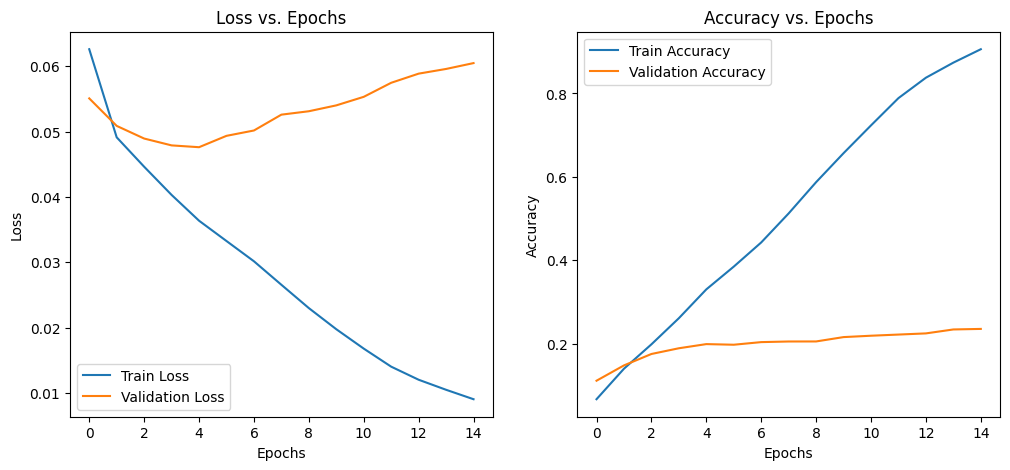

In [9]:
# Plotting
epochs = range(15)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')